In [3]:
# Import necessary libraries
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import tensorflow as tf
from tensorflow.keras import layers, models, Input
from tensorflow.keras.layers import Concatenate
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import cv2

# Load dataset paths and labels
train_data = pd.read_excel('train_data.xlsx')
object_ids = train_data['objectID'].astype(str).tolist()
labels = train_data['quality'].map({'GOOD': 1, 'BAD': 0}).tolist()

# Match file names based on object_id
image_folder = 'selected_photo'  # Folder where images are stored
file_paths = []

for obj_id in object_ids:
    matched_files = glob.glob(os.path.join(image_folder, f'*{obj_id}*.jpg'))
    if matched_files:
        file_paths.append(matched_files[0])
    else:
        # Handle cases where the image is not found
        print(f"Image not found for object ID: {obj_id}")

# Ensure that the length of file paths and labels are consistent
labels = labels[:len(file_paths)]

# Data preprocessing: Load images
def load_and_preprocess_images(file_paths, target_size=(224, 224)):
    images = []
    for file_path in file_paths:
        try:
            image = tf.keras.preprocessing.image.load_img(file_path, target_size=target_size, color_mode='rgb')
            image = tf.keras.preprocessing.image.img_to_array(image) / 255.0  # Normalize
            images.append(image)
        except Exception as e:
            print(f"Error loading image {file_path}: {e}")
            images.append(np.zeros((target_size[0], target_size[1], 3)))  # Placeholder black image
    return np.array(images)

# Load and preprocess images
images = load_and_preprocess_images(file_paths)

# Encode labels as numpy array
labels = np.array(labels)

# Split data into training and test sets (stratified)
X_train_full, X_test, y_train_full, y_test = train_test_split(
    images, labels, test_size=0.2, random_state=42, stratify=labels)

# Split training data into training and validation sets (stratified)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_full, y_train_full, test_size=0.2, random_state=42, stratify=y_train_full)

# Calculate blurriness feature
def calculate_blurriness(image):
    gray = cv2.cvtColor((image * 255).astype('uint8'), cv2.COLOR_RGB2GRAY)
    variance = cv2.Laplacian(gray, cv2.CV_64F).var()
    return variance

# Calculate features
def calculate_features(X):
    blurriness_scores = []
    for image in X:
        blurriness = calculate_blurriness(image)
        blurriness_scores.append(blurriness)
    return np.array(blurriness_scores)

# Calculate features for training, validation, and test sets
train_blurriness = calculate_features(X_train)
val_blurriness = calculate_features(X_val)
test_blurriness = calculate_features(X_test)

# Handle zero values (to avoid issues with log transformation)
train_blurriness[train_blurriness == 0] = 1e-6
val_blurriness[val_blurriness == 0] = 1e-6
test_blurriness[test_blurriness == 0] = 1e-6

# Apply log transformation to blurriness scores
train_blurriness_log = np.log(train_blurriness)
val_blurriness_log = np.log(val_blurriness)
test_blurriness_log = np.log(test_blurriness)

# Standardize features
scaler_blurriness = StandardScaler()
train_blurriness_scaled = scaler_blurriness.fit_transform(train_blurriness_log.reshape(-1, 1))
val_blurriness_scaled = scaler_blurriness.transform(val_blurriness_log.reshape(-1, 1))
test_blurriness_scaled = scaler_blurriness.transform(test_blurriness_log.reshape(-1, 1))

# Save scaler for future use
import joblib
joblib.dump(scaler_blurriness, 'scaler_blurriness.save')

# Calculate blurriness threshold and save it
blurriness_threshold = np.percentile(train_blurriness_scaled, 10)
np.save('blurriness_threshold.npy', blurriness_threshold)

# Data augmentation settings
train_image_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.15,
    height_shift_range=0.15,
    zoom_range=0.15,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Calculate class weights
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weight_dict = dict(zip(np.unique(y_train), class_weights))


# Define the model
# Image input
image_input = Input(shape=(224, 224, 3))
base_model = tf.keras.applications.EfficientNetB0(
    weights='imagenet', include_top=False, input_tensor=image_input)
base_model.trainable = False  # Freeze base model

x = base_model.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.BatchNormalization()(x)
x = layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
x = layers.Dropout(0.6)(x)

# Additional feature input
additional_input = Input(shape=(1,))
combined = Concatenate()([x, additional_input])

# Output layer
output = layers.Dense(1, activation='sigmoid')(combined)

# Define the complete model
model = models.Model(inputs=[image_input, additional_input], outputs=output)

# Compile the model
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
precision_metric = tf.keras.metrics.Precision(name='precision')
recall_metric = tf.keras.metrics.Recall(name='recall')
auc_metric = tf.keras.metrics.AUC(name='auc')

# Custom focal loss function
def focal_loss(gamma=1.0, alpha=0.75):
    gamma = float(gamma)
    alpha = float(alpha)

    def focal_loss_fixed(y_true, y_pred):
        y_true = tf.cast(y_true, tf.float32)
        y_pred = tf.cast(y_pred, tf.float32)
        epsilon = 1e-7  # Avoid division by zero
        y_pred = tf.clip_by_value(y_pred, epsilon, 1. - epsilon)
        pt = tf.where(tf.equal(y_true, 1), y_pred, 1 - y_pred)
        loss = -alpha * tf.pow(1. - pt, gamma) * tf.math.log(pt)
        return tf.reduce_mean(loss)
    return focal_loss_fixed

model.compile(
    optimizer=optimizer,
    loss=focal_loss(gamma=1.0, alpha=0.75),
    metrics=['accuracy', precision_metric, recall_metric, auc_metric]
)
# Callback functions
early_stopping = EarlyStopping(
    monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', factor=0.5, patience=2, min_lr=1e-7, verbose=1)

# Train the model
batch_size = 32

history = model.fit(
    [X_train, train_blurriness_scaled],
    y_train,
    batch_size=batch_size,
    epochs=30,
    validation_data=([X_val, val_blurriness_scaled], y_val),
    class_weight=class_weight_dict,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

# Unfreeze part of the base model for fine-tuning
base_model.trainable = True
fine_tune_at = int(len(base_model.layers) * 0.7)

for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

# Recompile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss=focal_loss(gamma=1.0, alpha=0.75),
    metrics=['accuracy', precision_metric, recall_metric, auc_metric]
)

# Continue training (fine-tuning)
history_fine = model.fit(
    [X_train, train_blurriness_scaled],
    y_train,
    batch_size=batch_size,
    epochs=10,
    validation_data=([X_val, val_blurriness_scaled], y_val),
    class_weight=class_weight_dict,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

# Save model weights
model.save_weights('best_model.weights.h5')

Training GOOD count: 573, BAD count: 227
Epoch 1/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 7s 155ms/step - accuracy: 0.9613 - loss: 0.3061 - val_accuracy: 0.9627 - val_loss: 0.1777
Epoch 2/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 6s 145ms/step - accuracy: 0.9606 - loss: 0.1753 - val_accuracy: 0.9627 - val_loss: 0.1605
Epoch 3/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 6s 141ms/step - accuracy: 0.9594 - loss: 0.1769 - val_accuracy: 0.9627 - val_loss: 0.1795
Epoch 4/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 7s 163ms/step - accuracy: 0.9492 - loss: 0.2073 - val_accuracy: 0.9627 - val_loss: 0.1598
Epoch 5/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 7s 168ms/step - accuracy: 0.9606 - loss: 0.1703 - val_accuracy: 0.9627 - val_loss: 0.1681
Epoch 6/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 7s 169ms/step - accuracy: 0.9529 - loss: 0.1918 - val_accuracy: 0.9627 - val_loss: 0.1603
Epoch 7/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 7s 182ms/step - accuracy: 0.9617 - loss: 0.1649 - val_accuracy: 0.9627 - val_loss: 0.1600
Epoch 8/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 7s 179ms/step - accuracy:

In [8]:
# Import necessary libraries
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import tensorflow as tf
from tensorflow.keras import layers, models, Input
from tensorflow.keras.layers import Concatenate
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import cv2

# Load dataset paths and labels
train_data = pd.read_excel('train_data.xlsx')
object_ids = train_data['objectID'].astype(str).tolist()
labels = train_data['quality'].map({'GOOD': 1, 'BAD': 0}).tolist()

# Match file names based on object_id
image_folder = 'selected_photo'  # Folder where images are stored
file_paths = []

for obj_id in object_ids:
    matched_files = glob.glob(os.path.join(image_folder, f'*{obj_id}*.jpg'))
    if matched_files:
        file_paths.append(matched_files[0])
    else:
        # Handle cases where the image is not found
        print(f"Image not found for object ID: {obj_id}")

# Ensure that the length of file paths and labels are consistent
labels = labels[:len(file_paths)]

# Data preprocessing: Load images
def load_and_preprocess_images(file_paths, target_size=(224, 224)):
    images = []
    for file_path in file_paths:
        try:
            image = tf.keras.preprocessing.image.load_img(file_path, target_size=target_size, color_mode='rgb')
            image = tf.keras.preprocessing.image.img_to_array(image) / 255.0  # Normalize
            images.append(image)
        except Exception as e:
            print(f"Error loading image {file_path}: {e}")
            images.append(np.zeros((target_size[0], target_size[1], 3)))  # Placeholder black image
    return np.array(images)

# Load and preprocess images
images = load_and_preprocess_images(file_paths)

# Encode labels as numpy array
labels = np.array(labels)

# Split data into training and test sets (stratified)
X_train_full, X_test, y_train_full, y_test = train_test_split(
    images, labels, test_size=0.2, random_state=42, stratify=labels)

# Split training data into training and validation sets (stratified)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_full, y_train_full, test_size=0.2, random_state=42, stratify=y_train_full)

# Calculate blurriness feature
def calculate_blurriness(image):
    gray = cv2.cvtColor((image * 255).astype('uint8'), cv2.COLOR_RGB2GRAY)
    variance = cv2.Laplacian(gray, cv2.CV_64F).var()
    return variance

# Calculate features
def calculate_features(X):
    blurriness_scores = []
    for image in X:
        blurriness = calculate_blurriness(image)
        blurriness_scores.append(blurriness)
    return np.array(blurriness_scores)

# Calculate features for training, validation, and test sets
train_blurriness = calculate_features(X_train)
val_blurriness = calculate_features(X_val)
test_blurriness = calculate_features(X_test)

# Handle zero values (to avoid issues with log transformation)
train_blurriness[train_blurriness == 0] = 1e-6
val_blurriness[val_blurriness == 0] = 1e-6
test_blurriness[test_blurriness == 0] = 1e-6

# Apply log transformation to blurriness scores
train_blurriness_log = np.log(train_blurriness)
val_blurriness_log = np.log(val_blurriness)
test_blurriness_log = np.log(test_blurriness)

# Standardize features
scaler_blurriness = StandardScaler()
train_blurriness_scaled = scaler_blurriness.fit_transform(train_blurriness_log.reshape(-1, 1))
val_blurriness_scaled = scaler_blurriness.transform(val_blurriness_log.reshape(-1, 1))
test_blurriness_scaled = scaler_blurriness.transform(test_blurriness_log.reshape(-1, 1))

# Save scaler for future use
import joblib
joblib.dump(scaler_blurriness, 'scaler_blurriness.save')

# Calculate blurriness threshold and save it
blurriness_threshold = np.percentile(train_blurriness_scaled, 10)
np.save('blurriness_threshold.npy', blurriness_threshold)

# Data augmentation settings
train_image_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.15,
    height_shift_range=0.15,
    zoom_range=0.15,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Calculate class weights
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weight_dict = dict(zip(np.unique(y_train), class_weights))


# Define the model
# Image input
image_input = Input(shape=(224, 224, 3))
base_model = tf.keras.applications.EfficientNetB0(
    weights='imagenet', include_top=False, input_tensor=image_input)
base_model.trainable = False  # Freeze base model

x = base_model.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.BatchNormalization()(x)
x = layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
x = layers.Dropout(0.6)(x)

# Additional feature input
additional_input = Input(shape=(1,))
combined = Concatenate()([x, additional_input])

# Output layer
output = layers.Dense(1, activation='sigmoid')(combined)

# Define the complete model
model = models.Model(inputs=[image_input, additional_input], outputs=output)

# Compile the model
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
precision_metric = tf.keras.metrics.Precision(name='precision')
recall_metric = tf.keras.metrics.Recall(name='recall')
auc_metric = tf.keras.metrics.AUC(name='auc')

# Custom focal loss function
def focal_loss(gamma=1.0, alpha=0.75):
    gamma = float(gamma)
    alpha = float(alpha)

    def focal_loss_fixed(y_true, y_pred):
        y_true = tf.cast(y_true, tf.float32)
        y_pred = tf.cast(y_pred, tf.float32)
        epsilon = 1e-7  # Avoid division by zero
        y_pred = tf.clip_by_value(y_pred, epsilon, 1. - epsilon)
        pt = tf.where(tf.equal(y_true, 1), y_pred, 1 - y_pred)
        loss = -alpha * tf.pow(1. - pt, gamma) * tf.math.log(pt)
        return tf.reduce_mean(loss)
    return focal_loss_fixed

model.compile(
    optimizer=optimizer,
    loss=focal_loss(gamma=1.0, alpha=0.75),
    metrics=['accuracy', precision_metric, recall_metric, auc_metric]
)
# Callback functions
early_stopping = EarlyStopping(
    monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', factor=0.5, patience=2, min_lr=1e-7, verbose=1)

# Train the model
batch_size = 32

history = model.fit(
    [X_train, train_blurriness_scaled],
    y_train,
    batch_size=batch_size,
    epochs=30,
    validation_data=([X_val, val_blurriness_scaled], y_val),
    class_weight=class_weight_dict,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

# Unfreeze part of the base model for fine-tuning
base_model.trainable = True
fine_tune_at = int(len(base_model.layers) * 0.7)

for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

# Recompile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss=focal_loss(gamma=1.0, alpha=0.75),
    metrics=['accuracy', precision_metric, recall_metric, auc_metric]
)

# Continue training (fine-tuning)
history_fine = model.fit(
    [X_train, train_blurriness_scaled],
    y_train,
    batch_size=batch_size,
    epochs=10,
    validation_data=([X_val, val_blurriness_scaled], y_val),
    class_weight=class_weight_dict,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

# Save model weights
model.save_weights('best_model.weights.h5')

Image not found for object ID: 5207
Epoch 1/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 29s 968ms/step - accuracy: 0.6451 - auc: 0.5164 - loss: 2.5943 - precision: 0.9504 - recall: 0.6580 - val_accuracy: 0.6875 - val_auc: 0.2683 - val_loss: 2.5008 - val_precision: 0.9462 - val_recall: 0.7154 - learning_rate: 1.0000e-04
Epoch 2/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 6s 369ms/step - accuracy: 0.8181 - auc: 0.4119 - loss: 2.4784 - precision: 0.9394 - recall: 0.8623 - val_accuracy: 0.7656 - val_auc: 0.2707 - val_loss: 2.4132 - val_precision: 0.9515 - val_recall: 0.7967 - learning_rate: 1.0000e-04
Epoch 3/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 6s 348ms/step - accuracy: 0.9114 - auc: 0.3701 - loss: 2.2901 - precision: 0.9563 - recall: 0.9509 - val_accuracy: 0.7969 - val_auc: 0.2675 - val_loss: 2.3249 - val_precision: 0.9533 - val_recall: 0.8293 - learning_rate: 1.0000e-04
Epoch 4/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 6s 361ms/step - accuracy: 0.9368 - auc: 0.4327 - loss: 2.2184 - precision: 0.9427 - recall: 0.9934 - val_accuracy: 

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 294ms/step
Confusion Matrix:
[[  6   1]
 [ 30 123]]
              precision    recall  f1-score   support

         BAD       0.17      0.86      0.28         7
        GOOD       0.99      0.80      0.89       153

    accuracy                           0.81       160
   macro avg       0.58      0.83      0.58       160
weighted avg       0.96      0.81      0.86       160



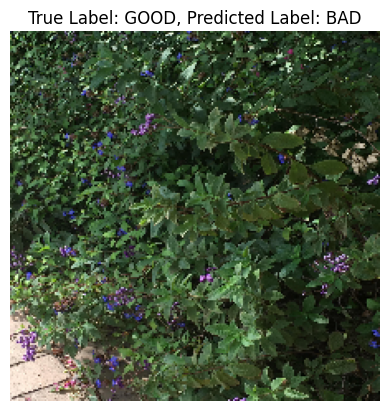

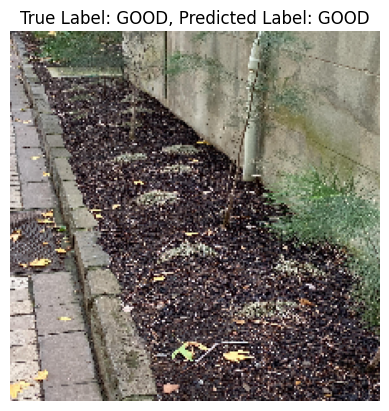

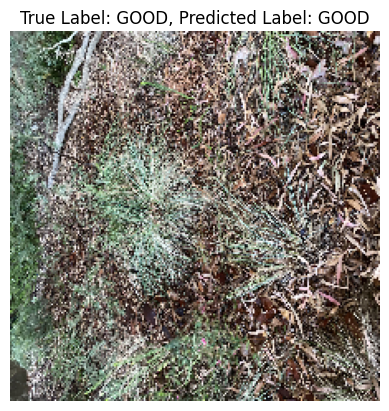

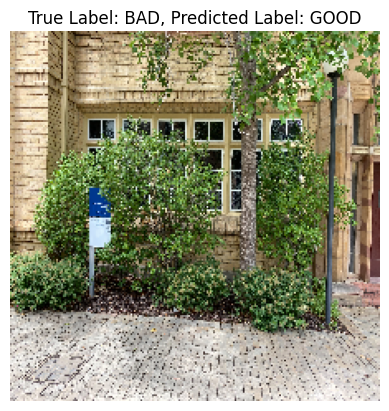

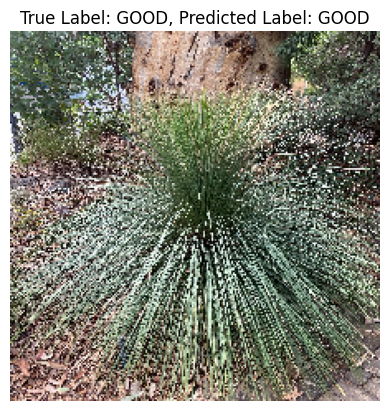

In [28]:
# Evaluate the model
y_pred_prob = model.predict([X_test, test_blurriness_scaled])
y_pred = (y_pred_prob >= 0.5).astype(int).flatten()
y_test_flat = y_test.flatten()

# Calculate ROC AUC
fpr, tpr, thresholds = roc_curve(y_test_flat, y_pred_prob)
auc_score = auc(fpr, tpr)
print(f"Test set AUC: {auc_score:.4f}")

# Confusion matrix and classification report
cm = confusion_matrix(y_test_flat, y_pred)
print(f"Confusion Matrix:\n{cm}")
print(classification_report(y_test_flat, y_pred, target_names=['BAD', 'GOOD']))

# Display misclassified images
misclassified_indices = np.where(y_pred != y_test_flat)[0]
print(f"Number of misclassified images: {len(misclassified_indices)}")

for idx in misclassified_indices[:5]:  # Display the first 5 misclassified images
    plt.imshow(X_test[idx], vmin=0, vmax=1)
    true_label = 'GOOD' if y_test_flat[idx] == 1 else 'BAD'
    pred_label = 'GOOD' if y_pred[idx] == 1 else 'BAD'
    plt.title(f"True Label: {true_label}, Predicted Label: {pred_label}")
    plt.axis('off')
    plt.show()

In [7]:
# 导入必要的库
import os
import glob
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, models, Input
from sklearn.preprocessing import StandardScaler
import cv2
import joblib

# 计算清晰度（模糊度）
def calculate_blurriness(image):
    gray = cv2.cvtColor((image * 255).astype('uint8'), cv2.COLOR_RGB2GRAY)
    variance = cv2.Laplacian(gray, cv2.CV_64F).var()
    return variance

# 加载训练时保存的标准化器和阈值
scaler_blurriness = joblib.load('scaler_blurriness.save')
blurriness_threshold = np.load('blurriness_threshold.npy')

# 加载训练好的模型
def load_trained_model(model_path):
    # 定义与训练时相同的模型架构
    image_input = Input(shape=(224, 224, 3))
    base_model = tf.keras.applications.EfficientNetB0(
        weights='imagenet', include_top=False, input_tensor=image_input)
    # 如果在训练中设置了 base_model.trainable = False，可以在这里也设置
    base_model.trainable = False

    x = base_model.output
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dense(128, activation='relu',
                     kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
    x = layers.Dropout(0.6)(x)

    additional_input = Input(shape=(1,))
    combined = layers.Concatenate()([x, additional_input])

    output = layers.Dense(1, activation='sigmoid')(combined)
    model = models.Model(inputs=[image_input, additional_input], outputs=output)

    # 加载权重
    model.load_weights(model_path)

    return model


# 主函数
def main():
    # 图像文件夹路径
    image_folder = 'photo'  # 更新为您的文件夹名称
    # 模型权重路径
    model_weights_path = 'best_model.weights.h5'  # 更新为您的模型权重文件

    # 获取图像文件路径列表
    image_extensions = ['jpg', 'jpeg', 'png']
    file_paths = []
    for ext in image_extensions:
        file_paths.extend(glob.glob(os.path.join(image_folder, f'*.{ext}')))

    if not file_paths:
        print("在指定的文件夹中未找到图像。")
        return

    # 加载训练好的模型
    model = load_trained_model(model_weights_path)

    # 准备保存结果的列表
    image_names_for_prediction = []
    predicted_classes = []
    predictions = []

    # 设置批量大小
    batch_size = 64

    # 处理图像的函数
    def process_batch(batch_paths):
        batch_images = []
        batch_blurriness_scores = []
        batch_image_names = []

        for file_path in batch_paths:
            try:
                # 加载图像
                image = tf.keras.preprocessing.image.load_img(
                    file_path, target_size=(224, 224), color_mode='rgb')
                image_array = tf.keras.preprocessing.image.img_to_array(image) / 255.0  # 归一化

                # 计算清晰度（模糊度）
                blurriness = calculate_blurriness(image_array)

                batch_images.append(image_array)
                batch_blurriness_scores.append(blurriness)
                batch_image_names.append(os.path.basename(file_path))
            except Exception as e:
                print(f"加载图像时出错 {file_path}: {e}")
                continue  # 跳过无法加载的图像

        if not batch_images:
            return

        # 转换为 numpy 数组
        images = np.array(batch_images)
        blurriness_scores = np.array(batch_blurriness_scores)

        # 处理为零的情况（避免对数变换的问题）
        blurriness_scores[blurriness_scores == 0] = 1e-6

        # 对模糊度分数进行对数变换
        blurriness_log = np.log(blurriness_scores)

        # 标准化清晰度特征
        blurriness_scaled = scaler_blurriness.transform(blurriness_log.reshape(-1, 1))

        # 初步筛选模糊的图片作为 BAD
        initial_bad_indices = np.where(blurriness_scaled < blurriness_threshold)[0]
        initial_good_indices = np.where(blurriness_scaled >= blurriness_threshold)[0]

        # 处理清晰的图片
        if len(initial_good_indices) > 0:
            images_for_prediction = images[initial_good_indices]
            blurriness_scaled_for_prediction = blurriness_scaled[initial_good_indices]
            image_names_good = [batch_image_names[i] for i in initial_good_indices]

            # 进行预测
            y_pred_prob = model.predict([images_for_prediction, blurriness_scaled_for_prediction])
            y_pred = (y_pred_prob >= 0.5).astype(int).flatten()

            # 保存结果
            image_names_for_prediction.extend(image_names_good)
            predicted_classes.extend(y_pred.tolist())
            predictions.extend(y_pred_prob.flatten().tolist())

        # 处理模糊的图片，直接标记为 BAD
        if len(initial_bad_indices) > 0:
            image_names_bad = [batch_image_names[i] for i in initial_bad_indices]
            image_names_for_prediction.extend(image_names_bad)
            predicted_classes.extend([0] * len(initial_bad_indices))  # BAD
            predictions.extend([0.0] * len(initial_bad_indices))  # 预测概率设为 0

    # 按批处理所有图像
    num_batches = len(file_paths) // batch_size + 1
    for i in range(num_batches):
        batch_paths = file_paths[i * batch_size : (i + 1) * batch_size]
        process_batch(batch_paths)
        print(f"已处理 {min((i + 1) * batch_size, len(file_paths))} / {len(file_paths)} 张图片")

    # 保存结果到 Excel
    result_df = pd.DataFrame({
        'Image': image_names_for_prediction,
        'Predicted Label': ['GOOD' if cls == 1 else 'BAD' for cls in predicted_classes],
        'Prediction Probability': predictions
    })

    # 保存到 Excel 文件
    output_file = 'classification_results.xlsx'
    result_df.to_excel(output_file, index=False)
    print(f"结果已保存到 {output_file}")

if __name__ == '__main__':
    main()


2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 400ms/step
已处理 64 / 17154 张图片
加载图像时出错 photo\ATT10099_Rhododendron indica_Photo 2.jpg: cannot identify image file <_io.BytesIO object at 0x0000027D332E0310>
加载图像时出错 photo\ATT10100_Rhododendron indica_Photo 1.jpg: cannot identify image file <_io.BytesIO object at 0x0000027D3635DD50>
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step  
已处理 128 / 17154 张图片
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 286ms/step
已处理 192 / 17154 张图片
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 285ms/step
已处理 256 / 17154 张图片
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 225ms/step
已处理 320 / 17154 张图片
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 280ms/step
已处理 384 / 17154 张图片
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 266ms/step
已处理 448 / 17154 张图片
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 282ms/step
已处理 512 / 17154 张图片
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 318ms/step
已处理 576 / 17154 张图片
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 278ms/step
已处理 640 / 17154 张图片
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 246ms/step
已处理 704 / 17154 张图片
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 246ms/step
已处理 768 / 17154 张图片
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 273ms/step
已处理